In [7]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import semidv
from numpy import genfromtxt
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"

dx=0.1e-9
dy=0.5e-9

Tch = 3e-9
Tsp = 5e-9
Tox = 0.5e-9
Thk = 1.5e-9
Lg = 6e-9 + Thk*2
Lsp = 6e-9
Lsd = 10e-9

Thickness = Tch + 2 * Tsp
Length = Lg + 2 * (Lsp + Lsd)

domain = (Thickness, Length)
steps = (dx, dy)
materials = [
    {"material": "Metal", "x": (0, Tsp-Tox-Thk), "y": (Lsd+Lsp+Thk, Length-Lsd-Lsp-Thk)},
    {"material": "Metal", "x": (Thickness-Tsp+Tox+Thk, Thickness), "y": (Lsd+Lsp+Thk, Length-Lsd-Lsp-Thk)},
    {"material": "HfO2", "x": (Tsp-Tox-Thk, Tsp-Tox), "y": (Lsd+Lsp, Length-Lsd-Lsp)},
    {"material": "HfO2", "x": (Thickness-Tsp+Tox, Thickness-Tsp+Tox+Thk), "y": (Lsd+Lsp, Length-Lsd-Lsp)},
    {"material": "HfO2", "x": (0, Tsp-Tox-Thk), "y": (Lsd+Lsp, Lsd+Lsp+Thk)},
    {"material": "HfO2", "x": (0, Tsp-Tox-Thk), "y": (Length-Lsd-Lsp-Thk, Length-Lsd-Lsp)},
    {"material": "HfO2", "x": (Thickness-Tsp+Tox+Thk, Thickness), "y": (Lsd+Lsp, Lsd+Lsp+Thk)},
    {"material": "HfO2", "x": (Thickness-Tsp+Tox+Thk, Thickness), "y": (Length-Lsd-Lsp-Thk, Length-Lsd-Lsp)}, 
    {"material": "SiO2", "x": (Tsp-Tox, Tsp), "y": (Lsd+Lsp, Length-Lsd-Lsp)},
    {"material": "SiO2", "x": (Thickness-Tsp, Thickness-Tsp+Tox), "y": (Lsd+Lsp, Length-Lsd-Lsp)},
    {"material": "Si3N4", "x": (0, Tsp), "y": (Lsd, Lsd+Lsp)},
    {"material": "Si3N4", "x": (0, Tsp), "y": (Length-Lsd-Lsp, Length-Lsd)},
    {"material": "Si3N4", "x": (Thickness-Tsp, Thickness), "y": (Lsd, Lsd+Lsp)},
    {"material": "Si3N4", "x": (Thickness-Tsp, Thickness), "y": (Length-Lsd-Lsp, Length-Lsd)}
]

parameters = semidv.material()
parameters.update_property("Si", "vsat_n", 2e7)
parameters.update_property("Si", "un", 310)
parameters.update_property("Si", "ua_n", 5e-9)
parameters.update_property("Metal", "xi", 4.415)
parameters.update_property("HfO2", "epsilon", 26)
parameters.update_property("Si3N4", "epsilon", 3)
doping = [
    {"type": "n-type", "concentration": 2e20, "x": (0, Thickness), "y": (0, Lsd)},
    {"type": "n-type", "concentration": 2e20, "x": (0, Thickness), "y": (Length-Lsd, Length)},
    {"type": "n-type", "concentration": "2e20*10**(-2*((y-"+str(Lsd)+")/"+str(Lsp)+")**2)", "x": (Tsp, Tsp+Tch), "y": (Lsd, Length)},
    {"type": "n-type", "concentration": "2e20*10**(-2*((y-"+str(Length-Lsd)+")/"+str(Lsp)+")**2)", "x": (Tsp, Tsp+Tch), "y": (0, Length-Lsd)},     
    {"type": "p-type", "concentration": 1e15, "x": (Tsp, Tsp+Tch), "y": (Lsd+Lsp, Length-Lsd-Lsp)}
]
gate1 = {"name": "gate1", "x": (0, Tsp-Tox-Thk), "y": (Lsd+Lsp, Length-Lsd-Lsp)}
gate2 = {"name": "gate2", "x": (Thickness-Tsp+Tox+Thk, Thickness), "y": (Lsd+Lsp, Length-Lsd-Lsp)}
channel = {"name": "channel", "x": (Tsp, Tsp+Tch), "y": (Lsd+Lsp, Length-Lsd-Lsp)}
total = {"name": "total", "x": (0, Thickness), "y": (0, Length)}
device = semidv.device(fermi=True, tolerance=1e-6, L=Lg)
device.build_device_structure(domain, steps, materials, doping)
device.materialproperties(parameters)
device.add_charge_region(gate1)
device.add_charge_region(gate2)
device.add_charge_region(channel)
device.add_charge_region(total)
device.Initialize()

Vs=0
Vd_sweep = np.array([0.05,0.15,0.65])
Vg_sweep = np.linspace(0,0.7,15)

boundary = [
      {"name": "gate", "contact": "yes", "type": "Dirichlet", "value": Vs, "barrier_height": 0, "x": (0, 0), "y": (Lsd+Lsp+Thk, Length-Lsd-Lsp-Thk)},
      {"name": "gate", "contact": "yes", "type": "Dirichlet", "value": Vs, "barrier_height": 0, "x": (Thickness, Thickness), "y": (Lsd+Lsp+Thk, Length-Lsd-Lsp-Thk)},
      {"name": "source", "contact": "yes", "type": "Dirichlet", "value": Vs, "barrier_height": 0, "x": (Thickness, Thickness), "y": (0, Lsd)},
      {"name": "drain", "contact": "yes", "type": "Dirichlet", "value": Vs, "barrier_height": 0, "x": (Thickness, Thickness), "y": (Length-Lsd, Length)}
  ]
results={}
results = semidv.solve(device, boundary, damping=1, recombination=False, quantum='e').IVsweep("gate", Vg_sweep, "drain", Vd_sweep, results)


Updated 'vsat_n' for material 'Si' to 20000000.0.
Updated 'un' for material 'Si' to 310.
Updated 'ua_n' for material 'Si' to 5e-09.
Updated 'xi' for material 'Metal' to 4.415.
Updated 'epsilon' for material 'HfO2' to 26.
Updated 'epsilon' for material 'Si3N4' to 3.
Error: 1.1413553612745437
Error: 0.023802648216054448
Error: 0.0011976316468687391
Error: 5.790889216884308e-06
Initialization success!
Solve Quantum-Poisson-Drift-Diffusion
gate: 0.0, drain: 0.05, Error: 0.09181875019985093
gate: 0.0, drain: 0.05, Error: 0.0954848209430416
gate: 0.0, drain: 0.05, Error: 0.05301325339707664
gate: 0.0, drain: 0.05, Error: 0.016060584184834685
gate: 0.0, drain: 0.05, Error: 0.004816131281489035
gate: 0.0, drain: 0.05, Error: 0.0018106368588482482
gate: 0.0, drain: 0.05, Error: 0.0007037869212137713
gate: 0.0, drain: 0.05, Error: 0.0002807088659261779
gate: 0.0, drain: 0.05, Error: 0.00011433927571492309
gate: 0.0, drain: 0.05, Error: 4.760476623495032e-05
gate: 0.0, drain: 0.05, Error: 2.00386

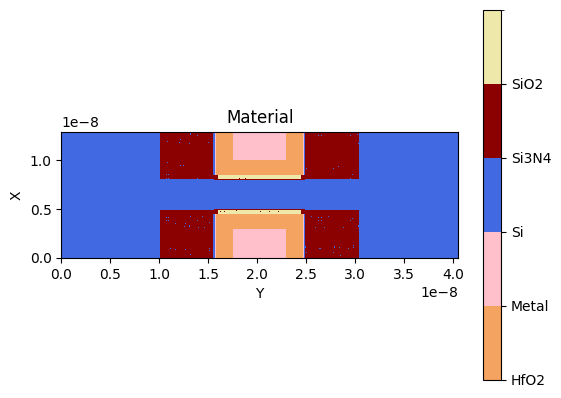

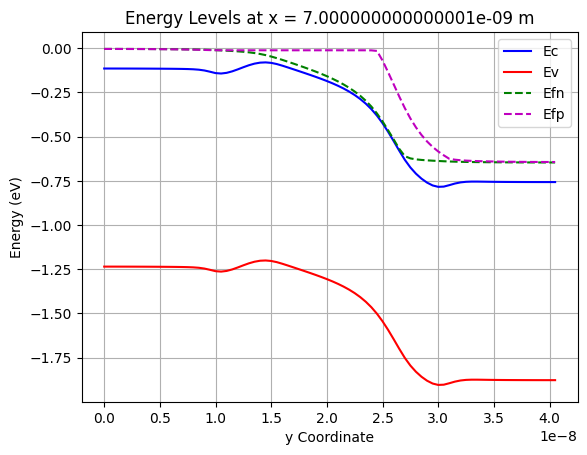

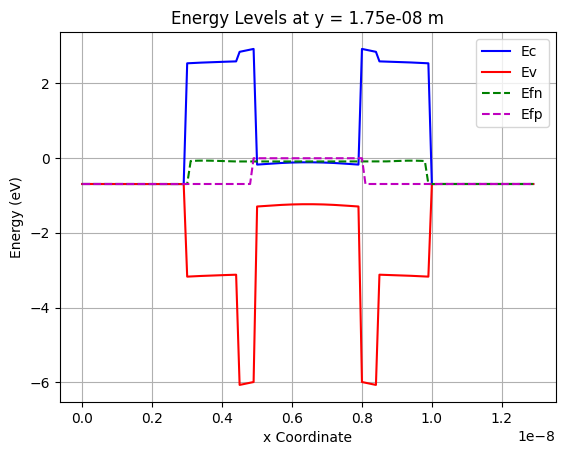

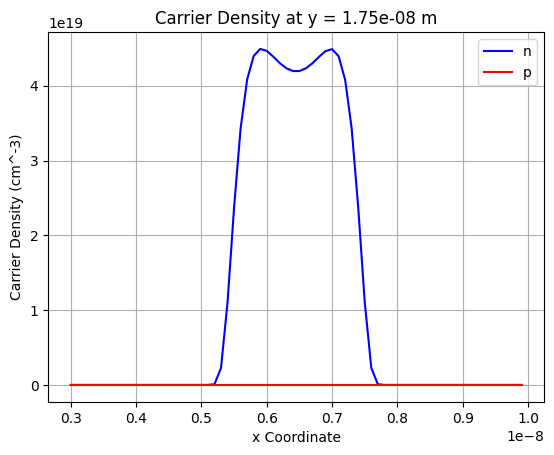

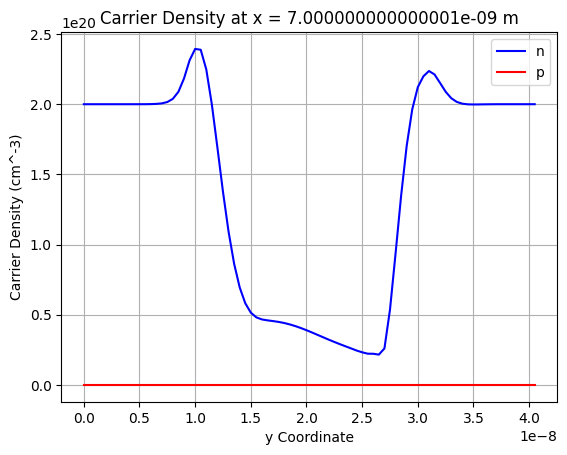

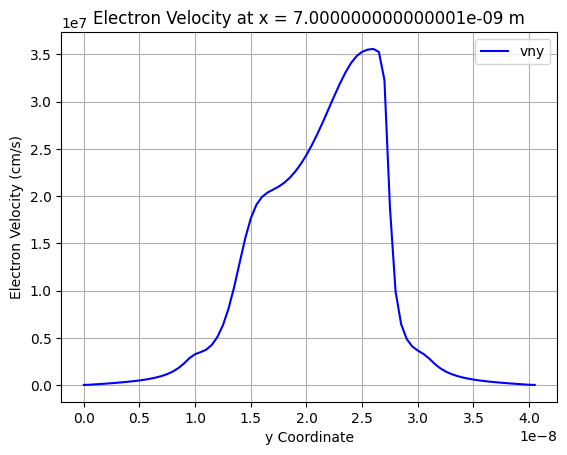

In [9]:
#Visualize Device Properties
y=Lsd+Lsp+Thk
x=Tsp+Tch-1e-9
device1 = results[(0.7, 0.65)]["model"]
deviceplot = semidv.visual(device1)
deviceplot.plot_structure()
deviceplot.plot_band_xcut(x)
deviceplot.plot_band_ycut(y)
deviceplot.plot_q_ycut(y)
deviceplot.plot_q_xcut(x)
deviceplot.plot_vn_xcut(x)     


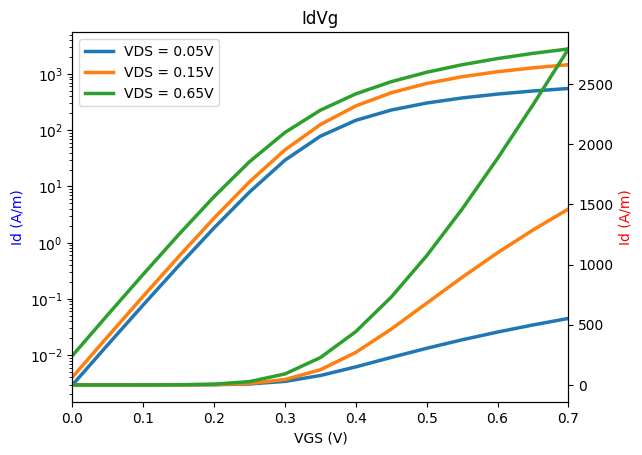

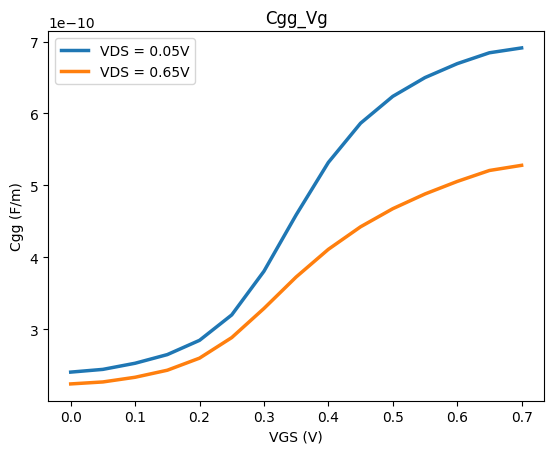

In [10]:
# IdVg Plot
Id = np.zeros([len(Vd_sweep),len(Vg_sweep)])
for index1, Vd in enumerate(Vd_sweep):
    for index2, Vg in enumerate(Vg_sweep):
        Vg = np.round(Vg,decimals=3)
        Vd = np.round(Vd,decimals=3)
        Id[index1,index2] = -results[(Vg, Vd)]["current"]["drain"]

fig, ax = plt.subplots()
# Plot on left y-axis (log scale)
for index1, Vd in enumerate(Vd_sweep):
    ax.plot(Vg_sweep, Id[index1, :], label=f"VDS = {Vd}V", linewidth=2.5)
ax.set_yscale('log')
ax.set_xlabel("VGS (V)")
ax.set_ylabel("Id (A/m)", color='b')
ax.legend()

# Create secondary axis (right)
ax2 = ax.twinx()
for index1, Vd in enumerate(Vd_sweep):
    ax2.plot(Vg_sweep, Id[index1, :], label=f"VDS = {Vd}V", linewidth=2.5)
ax2.set_ylabel("Id (A/m)", color='r')

# Show the plot
plt.title("IdVg")
plt.xlim([0,0.7])
plt.show()

# CggVg Plot
Qg = np.zeros([len(Vd_sweep),len(Vg_sweep)])
Qch = np.zeros([len(Vd_sweep),len(Vg_sweep)])
Q = np.zeros([len(Vd_sweep),len(Vg_sweep)])
for index1, Vd in enumerate(Vd_sweep):
    for index2, Vg in enumerate(Vg_sweep):
        Vg = np.round(Vg,decimals=3)
        Vd = np.round(Vd,decimals=3)
        Qg[index1, index2] = results[(Vg, Vd)]["charge"]["gate1"]+results[(Vg, Vd)]["charge"]["gate2"]
        Qch[index1, index2] = -results[(Vg, Vd)]["charge"]["channel"]

plt.figure()
for index1, Vd in enumerate(Vd_sweep):
    if Vd!=0.15:
        plt.plot(Vg_sweep, np.gradient(Qg[index1, :])/np.gradient(Vg_sweep), label=f"VDS = {Vd}V", linewidth=2.5)
# Show the plot
plt.xlabel("VGS (V)")
plt.ylabel("Cgg (F/m)") 
plt.title("Cgg_Vg")
plt.legend()
plt.show()